# Romney Tweets<br>
***

To start off, we first specify all the imports that we'll need for this notebook:

Run the following commands in the terminal to install the required packages

`pip install gensim` <br>
`pip install nltk` <br>
`pip install seaborn` <br>
`pip install sklearn` <br>
`pip install pandas` <br>
`pip install numpy` <br>

In [2]:
import nltk
import pandas as pd
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns
#models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# Setting our file paths
training_data_excel = 'C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/training-Obama-Romney-tweets.xlsx'
training_data_sheet = 'Romney'
sample_data_excel = 'C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/Test/final-testData-no-label-Romney-tweets.xlsx'
sample_data_sheet = 'Romney'
output_file = 'C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/utsav_Romney.txt'

We now load the data from the input excel into a dataframe

In [3]:
#data loading
data = pd.ExcelFile(training_data_excel)
romney = pd.read_excel(data, training_data_sheet)
romney.head(5)

,Unnamed: 0,date,time,Anootated tweet,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,"1: positive, -1: negative, 0: neutral, 2: mixed",Class,Your class label
1,NaN,2012-10-16 00:00:00,09:38:08-05:00,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1,NaN
2,NaN,2012-10-16 00:00:00,10:22:34-05:00,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2,NaN
3,NaN,2012-10-16 00:00:00,10:14:18-05:00,.@WardBrenda @shortwave8669 @allanbourdius you...,-1,NaN
4,NaN,2012-10-16 00:00:00,09:27:16-05:00,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1,NaN


## Data Cleaning and Lemmatization<br>
___

We can now start cleaning the data.<br>
We drop the first row from the dataframe:

In [4]:
romney = romney[1:]
romney.head(5)

,Unnamed: 0,date,time,Anootated tweet,Unnamed: 4,Unnamed: 5
1,NaN,2012-10-16 00:00:00,09:38:08-05:00,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1,NaN
2,NaN,2012-10-16 00:00:00,10:22:34-05:00,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2,NaN
3,NaN,2012-10-16 00:00:00,10:14:18-05:00,.@WardBrenda @shortwave8669 @allanbourdius you...,-1,NaN
4,NaN,2012-10-16 00:00:00,09:27:16-05:00,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1,NaN
5,NaN,2012-10-16 00:00:00,10:11:43-05:00,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1,NaN


Now, we can drop the columns that we do not need, namely: `Unnamed: 0`, `date`, `time` and `Unnamed: 5`.<br>
We also rename `Unnamed: 4 ` to `class` and `Anootated tweet` to `tweet`.

In [5]:
romney = romney.drop(['Unnamed: 0', 'date', 'time', 'Unnamed: 5'], axis=1)
romney = romney.rename(columns={'Unnamed: 4': 'class', 'Anootated tweet': 'tweet'})
romney.head(5)

,tweet,class
1,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
2,Senior <e>Romney</e> Advisor Claims <e>Obama</...,2
3,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
4,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
5,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1


We can check the number of classes available in the dataset:

In [6]:
print(romney['class'].value_counts())

-1      2893
0       1680
2       1351
1       1075
!!!!     169
IR         3
Name: class, dtype: int64


For this notebook, we are only interested in the classes `-1, 0 and 1`. Therefore, we drop all the other classes from the dataframe.<br>
We also change the column to be an integer, since the values are a mix of string and integers right now.

In [7]:
romney_df = romney[romney['class'].isin(['-1', '0', '1',-1,0,1])].copy(deep=True)
romney_df['class']=romney_df['class'].astype(int)
print(romney_df['class'].value_counts())
romney_df.head(5)

-1    2893
 0    1680
 1    1075
Name: class, dtype: int64


,tweet,class
1,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1
3,.@WardBrenda @shortwave8669 @allanbourdius you...,-1
4,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1
5,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1
6,Hope <e>Romney</e> debate prepped w/ the same ...,1


Now, we can start working on the actual tweets. The first few steps that we need to perform are cleaning the text itself and tokenizing it.<br>
For that, we use 2 functions:

In [8]:
def clean(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    text = re.sub(r'www.[^ ]+', '', text)
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text

regexp = RegexpTokenizer('\w+')

nltk.download('stopwords')

def tokenize(text):
    stop_words = stopwords.words('english')
    text = clean(text)
    text = regexp.tokenize(text)
    text = [w for w in text if w not in stop_words]
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The code cell below performs the task of going through our dataset, cleaning and tokenizing every tweet.

In [9]:
romney_df['tweet_token'] = romney_df['tweet'].apply(lambda stext: tokenize(str(stext)))

We then remove the words that are less than 2 characters, and appear less than 2 times, since those are most likely noise and would not contribute anything to our dataset.

In [10]:
#remove words with length less than 2
romney_df['tweet_string'] = romney_df['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
#Find a frequency distribution, and remove words with frequency less than 1
all_words = ' '.join([text for text in romney_df['tweet_string']])
tokenized_romney_df = nltk.tokenize.word_tokenize(all_words)
fdist = FreqDist(tokenized_romney_df)
romney_df['tweet_string_fdist'] = romney_df['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))

Now we have to perform the important task of Lemmatizing our dataset. To do this, we use `WordNetLemmatizer` with `Parts-Of-Speech tags`.

In [11]:
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatiser(text):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wordnet_tagged = map(lambda x: (x[0], pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\utsav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Applying this to our dataset:

In [12]:
romney_df['tweet'] = romney_df['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
romney_df.head(5)

,tweet,class,tweet_token,tweet_string,tweet_string_fdist
1,mitt romney bain help philip morris get high s...,-1,"[insidious, e, mitt, romney, e, bain, helped, ...",insidious mitt romney bain helped philip morri...,mitt romney bain helped philip morris get high...
3,mean like romney cheat primary,-1,"[mean, like, e, romney, e, cheated, primary]",mean like romney cheated primary,mean like romney cheated primary
4,mitt romney still believe black president,-1,"[e, mitt, romney, e, still, believe, black, pr...",mitt romney still believe black president,mitt romney still believe black president
5,romney tax plan deserve look secret one differ...,-1,"[e, romney, e, tax, plan, deserves, nd, look, ...",romney tax plan deserves look secret one diffe...,romney tax plan deserves look secret one diffe...
6,hope romney debate people last time,1,"[hope, e, romney, e, debate, prepped, w, peopl...",hope romney debate prepped people last time,hope romney debate people last time


We can drop the columns `tweet_token`, `tweet_string` and `tweet_string_fdist` now.<br>
We also remove the null values, to make sure that we do not have any empty records left after the previous steps.

In [13]:
romney_df = romney_df.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
romney_df.dropna(inplace=True)
print(romney_df.shape)
romney_df.head(5)

(5648, 2)


,tweet,class
1,mitt romney bain help philip morris get high s...,-1
3,mean like romney cheat primary,-1
4,mitt romney still believe black president,-1
5,romney tax plan deserve look secret one differ...,-1
6,hope romney debate people last time,1


We can now take a look at the distribution of the classes in our dataset:

In [14]:
print(romney_df['class'].value_counts())

-1    2893
 0    1680
 1    1075
Name: class, dtype: int64


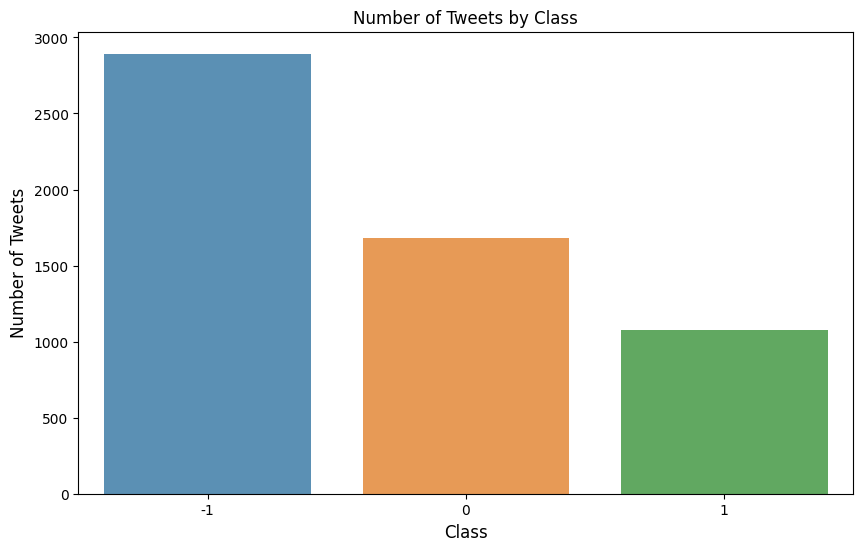

In [15]:
class_counts = romney_df['class'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Number of Tweets by Class')
plt.ylabel('Number of Tweets', fontsize=12)
plt.xlabel('Class', fontsize=12)

plt.show()

## Creating train and test data splits

Our data is now ready for processing. To train and test our models, we will perform a train-test-split of 80-20.

In [16]:
df_X = romney_df['tweet']
df_Y = romney_df['class']
X_train, X_test, y_train, y_test = train_test_split(df_X,df_Y,test_size=0.2,random_state = 1551)

## Vectorization<br>
___

### TF-IDF Vectorization

We will use `TfidfVectorizer` from `sklearn`.

In [17]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

### Word2Vec

We will also try using `Word2Vec` from `gensim`.

In [18]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [19]:
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

romney_df['tweet_w2v_token']=[nltk.word_tokenize(i) for i in romney_df['tweet']] 
model = Word2Vec(romney_df['tweet_w2v_token'],min_count=1) 
w2v = dict(zip(model.wv.index_to_key , model.wv.vectors))   
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.fit(X_train_tok,y_train)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)
romney_df.drop(['tweet_w2v_token'], axis=1, inplace=True)

To make sure that the negative numbers produced by this do not trip up our models, we use `MinMaxScaler` to normalize the values between 0 and 1.

In [20]:
scaler = MinMaxScaler()
X_train_vectors_w2v = scaler.fit_transform(X_train_vectors_w2v)
X_test_vectors_w2v = scaler.transform(X_test_vectors_w2v)

Now, we are ready to create and test on our models.

## Supervised Learning:<br>
___

Before we start running our models, to make things easier, we will create a dataframe to keep a track of our performance metrics.

In [21]:
performance = pd.DataFrame(columns=['Model','Vectorization','Accuracy', 'Precision', 'Recall', 'F1 Score'])

To make things even easier, I have written a small function to store our metrics in the dataframe.

In [22]:
def write_metrics(model_name,vector_name,test,predictions):
    global performance
    new_data = {'Model': model_name,
                'Vectorization': vector_name,
                'Accuracy': round(accuracy_score(test,predictions),4),
                'Precision': round(precision_score(test,predictions, average='weighted'),4),
                'Recall': round(recall_score(test,predictions, average='weighted'),4),
                'F1 Score': round(f1_score(test,predictions, average='weighted'),4)}
    performance = performance.append(new_data, ignore_index=True)

### Model 1: Logistic Regression

##### TF-IDF

In [23]:
lr_model_tfidf = LogisticRegression(solver='saga',C=5,penalty='l2',random_state=44) #4=57%
lr_model_tfidf.fit(X_train_vectors_tfidf, y_train)
lr_tfidf_y_pred = lr_model_tfidf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,lr_tfidf_y_pred))
write_metrics('Logistic Regression','TF-IDF',y_test,lr_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.63      0.78      0.70       579
           0       0.46      0.38      0.42       333
           1       0.53      0.34      0.41       218

    accuracy                           0.58      1130
   macro avg       0.54      0.50      0.51      1130
weighted avg       0.56      0.58      0.56      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


##### Word2Vec:

In [24]:
lr_model_w2v = LogisticRegression(solver='liblinear',C=10,penalty='l2',random_state=4) #4=57%
lr_model_w2v.fit(X_train_vectors_w2v, y_train)
lr_w2v_y_pred = lr_model_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,lr_w2v_y_pred))
write_metrics('Logistic Regression','Word2Vec',y_test,lr_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.54      0.92      0.68       579
           0       0.44      0.16      0.23       333
           1       0.55      0.05      0.09       218

    accuracy                           0.53      1130
   macro avg       0.51      0.38      0.33      1130
weighted avg       0.51      0.53      0.43      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


### Model 2: Naive Bayes

##### TF-IDF:

In [25]:
nb_tfidf_model = MultinomialNB()
nb_tfidf_model.fit(X_train_vectors_tfidf, y_train)
nb_tfidf_y_pred = nb_tfidf_model.predict(X_test_vectors_tfidf)
print(classification_report(y_test,nb_tfidf_y_pred))
write_metrics('Naive Bayes','TF-IDF',y_test,nb_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.54      0.97      0.69       579
           0       0.60      0.12      0.20       333
           1       0.72      0.10      0.17       218

    accuracy                           0.55      1130
   macro avg       0.62      0.40      0.36      1130
weighted avg       0.60      0.55      0.45      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


##### Word2Vec:

In [26]:
nb_w2v_model = MultinomialNB()
nb_w2v_model.fit(X_train_vectors_w2v, y_train)
nb_w2v_y_pred = nb_w2v_model.predict(X_test_vectors_w2v)
print(classification_report(y_test,nb_w2v_y_pred))
write_metrics('Naive Bayes','Word2Vec',y_test,nb_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.51      0.99      0.68       579
           0       0.00      0.00      0.00       333
           1       0.27      0.01      0.03       218

    accuracy                           0.51      1130
   macro avg       0.26      0.34      0.23      1130
weighted avg       0.32      0.51      0.35      1130



c:\Users\utsav\anaconda3\envs\CS418\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utsav\anaconda3\envs\CS418\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utsav\anaconda3\envs\CS418\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utsav\anacond

### Model 3: SVM

##### TF-IDF:

In [27]:
svm_tfidf_model = svm.SVC(kernel='linear', random_state=1564)
svm_tfidf_model.fit(X_train_vectors_tfidf, y_train)
svm_tfidf_y_pred = svm_tfidf_model.predict(X_test_vectors_tfidf)
print(classification_report(y_test,svm_tfidf_y_pred))
write_metrics('SVM','TF-IDF',y_test,svm_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.62      0.81      0.70       579
           0       0.49      0.35      0.40       333
           1       0.52      0.32      0.39       218

    accuracy                           0.58      1130
   macro avg       0.54      0.49      0.50      1130
weighted avg       0.56      0.58      0.56      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


##### Word2Vec:

In [28]:
svm_w2v_model = svm.SVC(kernel='linear', random_state=4)
svm_w2v_model.fit(X_train_vectors_w2v, y_train)
svm_w2v_y_pred = svm_w2v_model.predict(X_test_vectors_w2v)
print(classification_report(y_test,svm_w2v_y_pred))
write_metrics('SVM','Word2Vec',y_test,svm_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.51      1.00      0.68       579
           0       0.00      0.00      0.00       333
           1       0.00      0.00      0.00       218

    accuracy                           0.51      1130
   macro avg       0.17      0.33      0.23      1130
weighted avg       0.26      0.51      0.35      1130



c:\Users\utsav\anaconda3\envs\CS418\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utsav\anaconda3\envs\CS418\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utsav\anaconda3\envs\CS418\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utsav\anacond

### Model 4: KNN

##### TF-IDF:

In [29]:
knn_tfidf = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}#use gridsearch to test all values for n_neighbors
knn_tfidf_gscv = GridSearchCV(knn_tfidf, param_grid, cv=5)#fit model to data
clf = knn_tfidf_gscv.fit(X_train_vectors_tfidf, y_train)
knn_tfidf_y_pred = clf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,knn_tfidf_y_pred))
write_metrics('KNN','TF-IDF',y_test,knn_tfidf_y_pred)

              precision    recall  f1-score   support

          -1       0.56      0.84      0.67       579
           0       0.40      0.21      0.27       333
           1       0.42      0.17      0.24       218

    accuracy                           0.52      1130
   macro avg       0.46      0.40      0.39      1130
weighted avg       0.48      0.52      0.47      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


#### Word2Vec:

In [30]:
knn_w2v = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}#use gridsearch to test all values for n_neighbors
knn_w2v_gscv = GridSearchCV(knn_w2v, param_grid, cv=5)#fit model to data
clf_w2v = knn_w2v_gscv.fit(X_train_vectors_w2v, y_train)
knn_w2v_y_pred = clf_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,knn_w2v_y_pred))
write_metrics('KNN','Word2Vec',y_test,knn_w2v_y_pred)

              precision    recall  f1-score   support

          -1       0.53      0.91      0.67       579
           0       0.36      0.12      0.18       333
           1       0.29      0.03      0.05       218

    accuracy                           0.51      1130
   macro avg       0.39      0.35      0.30      1130
weighted avg       0.43      0.51      0.41      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


In [31]:
performance.head(10)

,Model,Vectorization,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,TF-IDF,0.5779,0.5617,0.5779,0.5605
1,Logistic Regression,Word2Vec,0.5265,0.5116,0.5265,0.4327
2,Naive Bayes,TF-IDF,0.5504,0.5952,0.5504,0.4491
3,Naive Bayes,Word2Vec,0.5106,0.3154,0.5106,0.3515
4,SVM,TF-IDF,0.5796,0.5612,0.5796,0.5551
5,SVM,Word2Vec,0.5124,0.2625,0.5124,0.3472
6,KNN,TF-IDF,0.5230,0.4843,0.5230,0.4703
7,KNN,Word2Vec,0.5071,0.4312,0.5071,0.4053


### Model 5: Voting Classifier

From this performance data, we can see that Logistic Regression, Naive Bayes and SVM have performance that is very close. Therefore, I use a Voting Classifier to create a model that predicts based on the votes from all 3 of these.

In [32]:
estimator = [] 
estimator.append(('LR', LogisticRegression(solver='saga',C=5,penalty='l2',random_state=44))) 
estimator.append(('Naive Bayes', MultinomialNB())) 
estimator.append(('SVM', svm.SVC(kernel='linear', random_state=4, probability=True)))
voting = VotingClassifier(estimators = estimator, voting ='soft') 
voting.fit(X_train_vectors_tfidf, y_train) 
y_pred_vot = voting.predict(X_test_vectors_tfidf) 
print(classification_report(y_test,y_pred_vot))
write_metrics('Voting','TF-IDF',y_test,y_pred_vot)

              precision    recall  f1-score   support

          -1       0.59      0.87      0.71       579
           0       0.48      0.26      0.34       333
           1       0.57      0.25      0.35       218

    accuracy                           0.57      1130
   macro avg       0.55      0.46      0.47      1130
weighted avg       0.56      0.57      0.53      1130



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


## Semi-Supervised<br>
***

As we can see from the statistics, we achieve a 57% accuracy using our Voting classifier. But, can we improve things further?<br>
If we look back to the start of this notebook, we dropped all records that were not in the classes -1, 0 and 1.<br>
However, that means we lose out on 1,544 records that are labelled as class 2 (mixed). These tweets express both positive and negative opinions.<br>
In our problem statement, we are only concered with the classes -1, 0 and 1. 
So, what if we were to perform semi-supervised learning and treat these as unlabelled data?

In [33]:
#take the records with class = 2
romney_mixed = romney[romney['class'].isin(['2',2])].copy(deep=True)
#change class type to int
romney_mixed['class']=romney_mixed['class'].astype(int)
romney_mixed['tweet_token'] = romney_mixed['tweet'].apply(lambda stext: tokenize(str(stext)))
# remove words with length less than 2
romney_mixed['tweet_string'] = romney_mixed['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
# find the frequesncy distribution and remove words with frequency less than 1
all_words = ' '.join([text for text in romney_mixed['tweet_string']])
tokenized_romney_mixed = nltk.tokenize.word_tokenize(all_words)
fdist = FreqDist(tokenized_romney_mixed)
romney_mixed['tweet_string_fdist'] = romney_mixed['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))
# lemmatize the words
romney_mixed['tweet'] = romney_mixed['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
# drop the columns that we do not need
romney_mixed = romney_mixed.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
# drop null values
romney_mixed.dropna(inplace=True)
# drop the class column
romney_mixed.drop(['class'], axis=1)
print(romney_mixed.shape)
romney_mixed.head(5)

(1351, 2)


,tweet,class
2,romney claim obama administration public libya,2
9,presidential debate round romney want obama,2
15,romney lead obama economy job deficit poll fin...,2
19,romney obama,2
33,romney crush obama tonight debate win election...,2


Creating TF-IDF vectors of these records,

In [34]:
mixed_vectors_tfidf = tfidf_vectorizer.transform(romney_mixed['tweet'])

We predict the classes for these records.

In [35]:
mixed_y_pred = lr_model_tfidf.predict(mixed_vectors_tfidf)

We add these classes to our `obama_mixed` dataframe,

In [36]:
romney_mixed['class'] = mixed_y_pred
romney_mixed.head()

,tweet,class
2,romney claim obama administration public libya,-1
9,presidential debate round romney want obama,-1
15,romney lead obama economy job deficit poll fin...,1
19,romney obama,0
33,romney crush obama tonight debate win election...,1


Merging these records with our existing dataframe `romney_df`,

In [37]:
romney_merged = romney_df.merge(romney_mixed, how='outer')
print(romney_merged.shape)

(7002, 2)


Now, we retrain our Voting Classifier on this new dataset:

In [38]:
ss_df_X = romney_merged['tweet']
ss_df_Y = romney_merged['class']
ss_X_train, ss_X_test, ss_y_train, ss_y_test = train_test_split(ss_df_X,ss_df_Y,test_size=0.2,random_state = 1551)

Convert the tweets into TF-IDF Vectors

In [39]:
ss_X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(ss_X_train)
ss_X_test_vectors_tfidf = tfidf_vectorizer.transform(ss_X_test)

Fit them to our Voting Classifier

In [40]:
voting.fit(ss_X_train_vectors_tfidf, ss_y_train) 
y_pred_vot_ss = voting.predict(ss_X_test_vectors_tfidf) 
print(classification_report(ss_y_test,y_pred_vot_ss))
write_metrics('Semi- Supervised Voting','TF-IDF',ss_y_test,y_pred_vot_ss)

              precision    recall  f1-score   support

          -1       0.66      0.86      0.75       703
           0       0.61      0.45      0.52       427
           1       0.67      0.41      0.51       271

    accuracy                           0.65      1401
   macro avg       0.65      0.57      0.59      1401
weighted avg       0.65      0.65      0.63      1401



C:\Users\utsav\AppData\Local\Temp\ipykernel_35920\2285202385.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(new_data, ignore_index=True)


This achieves 65% accuracy for the model.

## Sample Data<br>
***

Now that the model is ready, we can load, clean and tokenize the sample data excel.

In [41]:
#data loading
sample_data = pd.ExcelFile(sample_data_excel)
sample_romney = pd.read_excel(sample_data, sample_data_sheet)
if(len(sample_romney.columns) == 6):
    sample_romney = sample_romney[1:]
    sample_romney = sample_romney.drop(['Unnamed: 0', 'date', 'time', 'Unnamed: 5'], axis=1)
    sample_romney = sample_romney.rename(columns={'Unnamed: 4': 'class', 'Anootated tweet': 'tweet'})
    sample_romney = sample_romney[sample_romney['class'].isin(['-1', '0', '1',-1,0,1])]
    sample_romney['class']=sample_romney['class'].astype(int)
    #create a copy to use for printing to output file
    output_data = sample_romney.copy(deep=True)
    sample_romney['tweet_token'] = sample_romney['tweet'].apply(lambda stext: tokenize(str(stext)))
    #remove words with length less than 2
    sample_romney['tweet_string'] = sample_romney['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
    #Find a frequency distribution, and remove words with frequency less than 1
    all_words = ' '.join([text for text in sample_romney['tweet_string']])
    tokenized_sample_romney = nltk.tokenize.word_tokenize(all_words)
    fdist = FreqDist(tokenized_sample_romney)
    sample_romney['tweet_string_fdist'] = sample_romney['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))
    sample_romney['tweet'] = sample_romney['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
    sample_romney = sample_romney.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
    sample_romney.dropna(inplace=True)
    sample_df_X = sample_romney['tweet']
    sample_df_Y = sample_romney['class']
elif(len(sample_romney.columns) == 2):
    sample_romney = pd.read_excel(sample_data, sample_data_sheet,header=None)
    sample_romney.drop(sample_romney.columns[0], axis=1, inplace=True)
    sample_romney.columns = ['tweet']
    output_data = sample_romney.copy(deep=True)
    sample_romney['tweet_token'] = sample_romney['tweet'].apply(lambda stext: tokenize(str(stext)))
    #remove words with length less than 2
    sample_romney['tweet_string'] = sample_romney['tweet_token'].apply(lambda x:' '.join([item for item in x if len(item)>2]))
    #Find a frequency distribution, and remove words with frequency less than 1
    all_words = ' '.join([text for text in sample_romney['tweet_string']])
    tokenized_sample_romney = nltk.tokenize.word_tokenize(all_words)
    fdist = FreqDist(tokenized_sample_romney)
    sample_romney['tweet_string_fdist'] = sample_romney['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] > 1 ]))
    sample_romney['tweet'] = sample_romney['tweet_string_fdist'].apply(lambda x: lemmatiser(x))
    sample_romney = sample_romney.drop(['tweet_token', 'tweet_string', 'tweet_string_fdist'], axis=1)
    sample_romney.dropna(inplace=True)
    sample_df_X = sample_romney['tweet']
else:
    print("Invalid columns - check the excel file")
X_sample_vectors = tfidf_vectorizer.transform(sample_df_X)
print(sample_romney.shape)
sample_romney.head(5)

(1900, 1)


,tweet
0,romney get less minute debate candy crowley still
1,mitt record character
2,actually like romney response immigration
3,immigration statement romney answer enough get...
4,man romney dude economics


Predicting for our sample test data:

In [42]:
sample_y_pred = voting.predict(X_sample_vectors)

Finally, we write our predicted classes to an excel sheet.

In [43]:
# output_data['Predicted class'] = sample_y_pred
# output_data.to_excel(output_file, index=False, sheet_name=sample_data_sheet)

In [44]:
output_file = open(output_file, "w")
output_file.write("(setf x ‘(\n")

for i in range(len(sample_y_pred)):
    line = "("+str(i+1)+" "+str(sample_y_pred[i])+")"
    output_file.write(str(line))
    output_file.write('\n')
output_file.write("))")
output_file.close()

In [45]:
# performance.to_csv('C:/Users/utsav/OneDrive/UIC/Fall_2023/CS_583/Project/performance_romney.csv', index=False)

Resources:<br>
https://www.kirenz.com/post/2021-12-11-text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/ <br>
https://medium.com/@qacbustamante/natural-language-processing-using-python-part-1-958d4ea1846e <br>
https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/ <br>